# Project 3: Predictive modeling
*University of Ljubljana, Faculty for computer and information science* <br />
*Course: Introduction to data science*

## Environment setup

- Libraries needed to run this notebook are: pandas, numpy, matplotlib, datetime, itertools and sklearn.

- Run the following commands to set up the environment:
 
> conda create -n project3 python=3.9 pandas matplotlib

> conda activate project3

> conda install -c conda-forge scikit-learn

- Or use project3_env.yml file from the same GitHub repository to setup the enviroment with command:

> conda create -f project3_env.yml

In [120]:
# Loading all the libraries needed for running the code chunks below

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 

## Loading and preparing the data

In [2]:
policy_data = pd.read_csv('policy_data.csv')
policy_data.head()  # total number of rows 15 279 995

C:\Users\Asus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,underwriting_date,first_end_date,cancellation_or_end_date,policy_id,sales_channel,customer_id,premium,status,line,product_name,product_group
0,NaN,NaN,NaN,0,0.0,697.0,NaN,1,0,NaN,NaN
1,NaN,NaN,NaN,1,0.0,1499.0,NaN,1,0,0.0,0.0
2,NaN,NaN,NaN,2,0.0,2710.0,NaN,1,0,NaN,NaN
3,NaN,NaN,NaN,3,1.0,4483.0,NaN,1,0,NaN,NaN
4,NaN,NaN,NaN,4,0.0,7920.0,NaN,1,0,NaN,NaN


In [3]:
customer_data = pd.read_csv('customer_data.csv')
customer_data.drop(['country_part','date_of_birth','household_id','household_role'], inplace = True, axis = 1)

# there are 2 333 031 rows total, without dropping NaN values
customer_data.dropna(subset = ['customer_type'], inplace = True) # 2 332 634 rows left after dropping NaN values

# combining customer_type and gender column
customer_data = customer_data.fillna('')
customer_data['gender'] = customer_data['gender'].replace(['female'], '_female')
customer_data['gender'] = customer_data['gender'].replace(['male'], '_male')

customer_data['customer_type'] = customer_data['customer_type'] + customer_data['gender']
customer_data.drop(['gender'], axis = 1, inplace = True)
customer_data.drop(customer_data.index[customer_data['customer_type'] == 'natural_person'], inplace = True) # 2 332 454 rows left


customer_data.head()

,customer_id,customer_type
0,0,business
1,1,business
3,3,business
4,4,business
5,5,business


In [4]:
# creating new data frame
df = policy_data.copy()

# removing active policies
df.dropna(subset = ['cancellation_or_end_date'], inplace = True) # 10 874 384 rows left that represent non active policies

# removing rows with missing data
df.dropna(subset = ['underwriting_date', 'first_end_date'], inplace = True) # 10 250 962 policies left
df.reset_index(drop = True, inplace = True)

# sorting by underwriting_date
df = df.sort_values('underwriting_date')
df.reset_index(drop = True, inplace = True)

# converting dates to datetime format
df['underwriting_date'] = pd.to_datetime(df['underwriting_date'], format = '%Y-%m-%d')
df['first_end_date'] = pd.to_datetime(df['first_end_date'], format = '%Y-%m-%d')
df['cancellation_or_end_date'] = pd.to_datetime(df['cancellation_or_end_date'], format = '%Y-%m-%d')

# calculationg for how long the policy was active
diff_month = (df['cancellation_or_end_date'].dt.month - df['underwriting_date'].dt.month)
diff_year = (df['cancellation_or_end_date'].dt.year - df['underwriting_date'].dt.year)
diff = [(diff_year[i]*12 + diff_month[i]) for i in range(0, len(diff_year))]

# calculation for how long was the policy signed before extension
diff_month_d = (df['first_end_date'].dt.month - df['underwriting_date'].dt.month)
diff_year_d = (df['first_end_date'].dt.year - df['underwriting_date'].dt.year)
diff_d = [(diff_year_d[i]*12 + diff_month_d[i]) for i in range(0, len(diff_year_d))]

In [5]:
# if first_end_date > cancellation_or_end_date policy is closed prematurely
# if first_end_date = cancellation_or_end_date policy is closed after expiring
# if first_end_date < cancellation_or_end_date policy was prolonged

extension = (df['cancellation_or_end_date'] - df['first_end_date']).dt.days
duration_status = []
for i in extension:
    if i < 0 :
        duration_status.append(0)
    elif i == 0 :
        duration_status.append(1)
    else:
        duration_status.append(2)

# adding columns to new data frame df        
df['duration'] = diff
df['first_end_duration'] = diff_d
df['duration_status'] = duration_status
df['underwriting_year'] = df['underwriting_date'].dt.year

# removing redundant columns
df.drop(['first_end_date','cancellation_or_end_date', 'sales_channel', 'status'], axis = 1, inplace = True)

df.head()        

,underwriting_date,policy_id,customer_id,premium,line,product_name,product_group,duration,first_end_duration,duration_status,underwriting_year
0,1963-01-06,11834427,1715488.0,215.0,1,24.0,23.0,444,120,2,1963
1,1963-07-24,9696078,1332848.0,4.0,1,15.0,15.0,456,120,2,1963
2,1965-05-21,7007602,843685.0,NaN,1,24.0,23.0,432,432,1,1965
3,1966-07-07,1816629,15402.0,33.0,1,8.0,8.0,480,120,2,1966
4,1966-09-28,8543990,1119187.0,16.0,1,19.0,19.0,408,120,2,1966


# Modeling

### Predicting duration of the policy in months - Regression

In [6]:
# Creating new data frame for regression

# merging with customer_data 
data_r = pd.merge(df, customer_data , how='inner', left_on = 'customer_id', right_on = 'customer_id') # 10 250 245 rows left 

# removing redundant columns
columns_drop = ['underwriting_date', 'policy_id', 'product_name']
data_r.drop(columns_drop, axis = 1, inplace = True)
data_r.drop(['duration_status'], axis = 1, inplace = True)

# removing rows with NaN values
data_r.dropna(how = 'any', axis = 0, inplace = True) # 10 245 799 rows left
data_r.reset_index(drop = True, inplace = True)

# transforming customer_type into dummy variables
customer_dummy = pd.get_dummies(data_r.customer_type)
data_r = pd.concat([data_r, customer_dummy], axis = 1)
data_r.drop(['customer_type'], axis = 1, inplace = True)

data_r.head()

,customer_id,premium,line,product_group,duration,first_end_duration,underwriting_year,business,natural_person_female,natural_person_male
0,1715488.0,215.0,1,23.0,444,120,1963,0,0,1
1,1332848.0,4.0,1,15.0,456,120,1963,0,1,0
2,1332848.0,267.0,2,6.0,58,10,1996,0,1,0
3,1332848.0,258.0,2,6.0,116,12,2001,0,1,0
4,1332848.0,320.0,2,6.0,100,4,2010,0,1,0


In [127]:
# Defining a funtion that splits, scales, trains, tests and evalues

def regression(model):
    
    k_fold = KFold(n_splits=5, shuffle = True, random_state = 1)
    errors = []
    
    for train_index, test_index in k_fold.split(X, y):

        X_train = X.loc[train_index]
        y_train = y.loc[train_index]

        X_test  = X.loc[test_index]
        y_test  = y.loc[test_index]
        
        reg = model
        
        if reg == GradientBoostingRegressor():
            scaler = MinMaxScaler().fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
        
        reg.fit(X_train,y_train)
        y_pred = reg.predict(X_test)

        # accuracy for the current fold only 
        mae_fold = metrics.mean_absolute_error(y_test, y_pred)
        errors.append(mae_fold)
    
    # average accuracy accross all splits
    average_mae = np.mean(errors)
    
    # get feature importances
    try:
        ft_imp = reg.feature_importances_
    except:
        ft_imp = 0
        
    return average_mae, errors, ft_imp

In [144]:
# Defining parameters X and taget variable y
X = data_r.copy()
X.drop(['duration'], axis = 1, inplace = True)
y = data_r['duration']

In [57]:
# MEAN DUMMY REGRESSOR
model = DummyRegressor(strategy = 'mean')
meandummy_mae, meandummy_mae_splits, meandummy_ft_imp = regression(model)
print('MeanDummy_MAE:', meandummy_mae)

# MEDIAN DUMMY REGRESSOR
model = DummyRegressor(strategy = 'median')
mediandummy_mae, mediandummy_mae_splits, mediandummy_ft_imp = regression(model)
print('MedianDummy_MAE:', mediandummy_mae)

MeanDummy_MAE: 17.811229754960014
MedianDummy_MAE: 13.908942972741352


In [22]:
# DECISION TREE REGRESSOR
for i in [5, 10, 20, 30]:
    model = DecisionTreeRegressor(max_depth = i)
    DT_mae, DT_mae_splits, DT_ft_imp = regression(model)
    print('Max DT depth:', i)
    print('DecisionTree_MAE:', DT_mae)

Max DT depth: 5
DecisionTree_MAE: 12.893803401340033
Max DT depth: 10
DecisionTree_MAE: 11.952576616860815
Max DT depth: 20
DecisionTree_MAE: 11.840875192542232
Max DT depth: 30
DecisionTree_MAE: 12.672470937305967


In [38]:
# GRADIENT BOOSTING REGRESSOR
model = GradientBoostingRegressor()
GBR_mae, GBR_mae_splits, GBR_ft_imp = regression(model)
print('GBR_MAE:', GBR_mae)
print('GBR_MAE_splits', GBR_mae_splits)

GBR_MAE: 12.295898970078126
GBR_MAE_splits [12.283974119439, 12.315631897948764, 12.302657572759841, 12.293660865808626, 12.283570394434399]


In [23]:
# DECISION TREE REGRESSOR
model = DecisionTreeRegressor(max_depth = 20)
DT_mae, DT_mae_splits, DTR_ft_imp = regression(model)
print('Max DT depth:', 20)
print('DecisionTree_MAE:', DT_mae)
print('Feature Importances', DTR_ft_imp)

Max DT depth: 20
DecisionTree_MAE: 11.841947006931349


In [145]:
# RANDOM FOREST REGRESSOR
model = RandomForestRegressor(max_depth = 20)
RF_mae, RF_mae_splits, RFR_ft_imp = regression(model)
print('Max RF depth:', 20)
print('RandomForest_MAE:', RF_mae)
print('RandomForest_MAE_splits', RF_mae_splits)
print('Feature Importances', RFR_ft_imp)

Max RF depth: 20
RandomForest_MAE: 11.636085907151138
RandomForest_MAE_splits [11.63602182938843, 11.637032441933508, 11.654978577931738, 11.62602463965649, 11.626372046845518]
Feature Importances [5.01001127e-02 6.99298110e-02 4.02103744e-02 7.67755826e-02
 5.28076383e-01 2.31009713e-01 4.05015088e-04 2.02763484e-03
 1.46537288e-03]


### Predicting if the policy will end prematurely/on time/be extended - Classification

In [25]:
# Creating new data frame for classification

# merging with customer_data 
data_c = pd.merge(df, customer_data , how='inner', left_on = 'customer_id', right_on = 'customer_id') # 10 250 245 rows left 

# removing redundant columns
data_c.drop(columns_drop, axis = 1, inplace = True)
data_c.drop(['duration'], axis = 1, inplace = True)

# removing rows with NaN values
data_c.dropna(how = 'any', axis = 0, inplace = True) # 10 245 799 rows left
data_c.reset_index(drop = True, inplace = True)

# transforming customer_type into dummy variables
customer_dummy = pd.get_dummies(data_c.customer_type)
data_c = pd.concat([data_c, customer_dummy], axis = 1)
data_c.drop(['customer_type'], axis = 1, inplace = True)

data_c.head()

,customer_id,premium,line,product_group,first_end_duration,duration_status,underwriting_year,business,natural_person_female,natural_person_male
0,1715488.0,215.0,1,23.0,120,2,1963,0,0,1
1,1332848.0,4.0,1,15.0,120,2,1963,0,1,0
2,1332848.0,267.0,2,6.0,10,2,1996,0,1,0
3,1332848.0,258.0,2,6.0,12,2,2001,0,1,0
4,1332848.0,320.0,2,6.0,4,2,2010,0,1,0


In [138]:
def classification(model):
    
    k_fold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1)
    scores = []
    y_proba = []
    
    for train_index, test_index in k_fold.split(X, y):

        X_train = X.loc[train_index]
        y_train = y.loc[train_index]

        X_test  = X.loc[test_index]
        y_test  = y.loc[test_index]
        
        scaler = MinMaxScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
        clf = model  
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        
        try:
            y_proba_split = clf.predict_proba(X_test)
        except:
            y_proba_split = 0

        # accuracy for the current fold only 
        score_fold = metrics.accuracy_score(y_test, y_pred)
        scores.append(score_fold)
        y_proba.append(y_proba_split)
        
    average_score = np.mean(scores)
    
    # get feature importances
    try:
        ft_imp = clf.feature_importances_
    except:
        ft_imp = 0
        
    return average_score, scores, ft_imp, y_proba

In [139]:
# Defining parameters and target variable
X = data_c.copy()
X.drop(['duration_status'], axis = 1, inplace = True)
y = data_c['duration_status']

In [29]:
# DUMMY MAJORITY CLASSIFIER
model = DummyClassifier(strategy = 'most_frequent')
dummy_acc, dummy_acc_splits, dummy_ft_imp, dummy_proba = classification(model)
print('Dummy_acc:', dummy_acc)

Dummy_acc: 0.502055232588498


In [140]:
# MULTYNOMIAL LOGISTIC REGRESSION
model = LogisticRegression(multi_class = 'multinomial', solver = 'sag', n_jobs = -1)
MLR_acc, MLR_acc_splits, MLR_ft_imp, MLR_proba = classification(model)
print('MLR_acc:', MLR_acc)
print('MLR acc per split', MLR_acc_splits)

MLR_acc: 0.5489065323284235
MLR acc per split [0.5487917000136642, 0.5487375314763122, 0.5492479845400067, 0.5488248843428527, 0.5489305612692816]


In [34]:
# DECISION TREE CLASSIFIER
for i in [5, 10, 20, 30]:
    model = DecisionTreeClassifier(max_depth = i)
    DT_acc, DT_acc_splits, DT_ft_imp, DT_proba = classification(model)
    print('Max DT depth:', i)
    print('DT_acc:', DT_acc)

Max DT depth: 5
DT_acc: 0.5640833867842379
Max DT depth: 10
DT_acc: 0.6093953238856022
Max DT depth: 20
DT_acc: 0.6241409772239406
Max DT depth: 30
DT_acc: 0.6016945091333088


In [35]:
# DECISION TREE CLASSIFIER
model = DecisionTreeClassifier(max_depth = 20)
DT_acc, DT_acc_splits, DT_ft_imp, DT_proba = classification(model)
print('Max DT depth:', 20)
print('DT_acc:', DT_acc)
print('DT acc per split', DT_acc_splits)
print('DT feature importances', DT_ft_imp)

Max DT depth: 20
DT_acc: 0.6241371707853711
DT acc per split [0.6240864549376329, 0.6239137012239161, 0.6237931640281872, 0.6244597786410041, 0.6244327550961151]
DT feature importances [5.71503868e-02 9.30153354e-02 4.00111471e-02 3.92404527e-01
 2.28657238e-01 1.84082934e-01 2.01475569e-04 2.37432745e-03
 2.10262933e-03]


In [43]:
# RANDOM FOREST CLASSIFIER
model = RandomForestClassifier(max_depth = 20)
RF_acc, RF_acc_splits, RF_ft_imp, RF_proba = classification(model)
print('Max RF depth:', 20)
print('RF_acc:', RF_acc)
print('RF acc per split', RF_acc_splits)
print('RF feature importances', RF_ft_imp)

Max RF depth: 20
RF_acc: 0.628627401359313
RF acc per split [0.628343809170587, 0.6287639813386949, 0.6282793925315739, 0.6289025747135412, 0.628847249042168]
RF feature importances [0.07024712 0.10611659 0.07059308 0.31079162 0.23099775 0.1957463
 0.01123377 0.00184467 0.0024291 ]


In [142]:
# MULTI LAYER PERCEPTRON
model = MLPClassifier(learning_rate_init = 0.01, max_iter = 50, tol = 0.01, n_iter_no_change = 5)
MLP_acc, MLP_acc_splits, MLP_ft_imp, MLP_proba = classification(model)
print('MLP_acc:', MLP_acc)
print('MLP_acc_splits', MLP_acc_splits)
print('MLP_ft_imp', MLP_ft_imp)

MLP_acc: 0.5851965282968952
MLP_acc_splits [0.5850182513810537, 0.5835249565675692, 0.5819003884518534, 0.5859147162739854, 0.5896243288100143]
MLP_ft_imp 0


### Visualizations

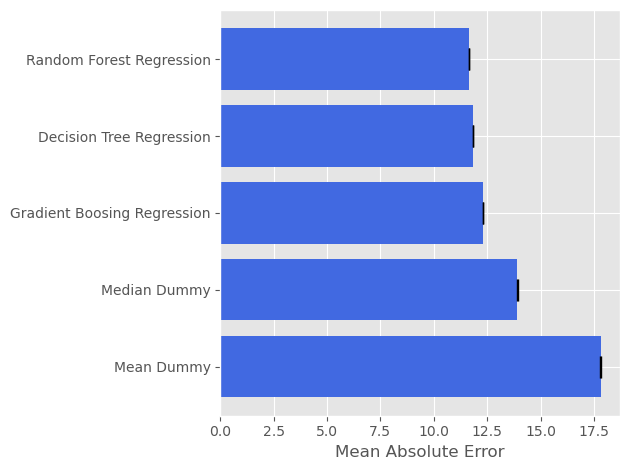

In [147]:
# Visualization 1: Comparison of MAE of regression models 
plt.style.use('ggplot')

# calculating standard deviation across splits
meandummy_std = np.std(meandummy_mae_splits)
mediandummy_std = np.std(mediandummy_mae_splits)
DTR_std = np.std(DT_mae_splits)
RFR_std = np.std(RF_mae_splits)
GBR_std = np.std(GBR_mae_splits)

mean_mae = [meandummy_mae, mediandummy_mae, GBR_mae, DT_mae, RF_mae]
std_mae = [meandummy_std, mediandummy_std, GBR_std, DTR_std, RFR_std]

model_reg = ['Mean Dummy', 'Median Dummy', 'Gradient Boosing Regression', 'Decision Tree Regression', 'Random Forest Regression']
x_reg = np.arange(len(model_reg))

# building the plot
fig, ax = plt.subplots()
ax.barh(x_reg, mean_mae, xerr=std_mae, align='center', alpha=1.0, ecolor='black', capsize=8, color = 'royalblue')
ax.set_xlabel('Mean Absolute Error')
ax.set_yticks(x_reg)
ax.set_yticklabels(model_reg)

# saving the figure 
plt.tight_layout()
plt.savefig('regression_MAE.png')
plt.show()

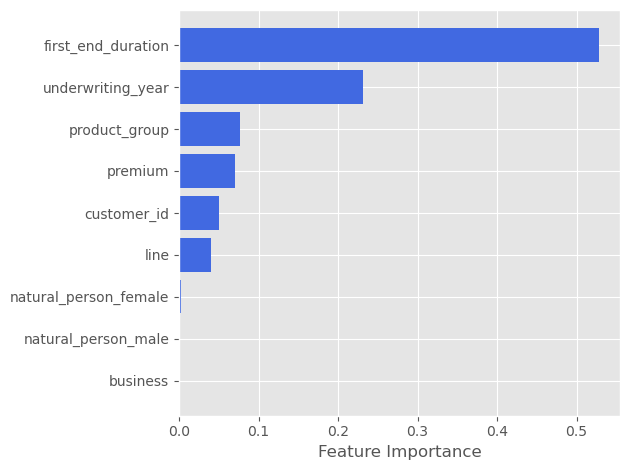

In [146]:
# Visualization 2: Random Forest Regressor feature importance

features_r = data_r.columns
features_r = features_r.drop('duration')
sort_idx = RFR_ft_imp.argsort()

plt.barh(features_r[sort_idx], RFR_ft_imp[sort_idx], color = 'royalblue')
plt.xlabel('Feature Importance')

# saving the figure
plt.tight_layout()
plt.savefig('RFR_feature_importance.png')
plt.show()

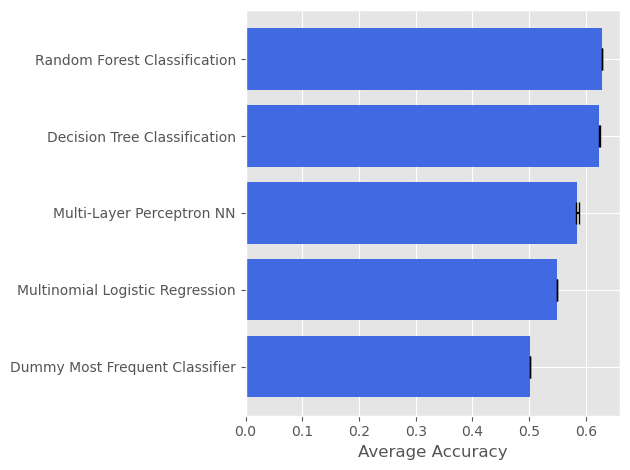

In [143]:
# Visualization 3: Average accuracy comparison of the classification models 

# calculating standard deviation across splits
dummy_std = np.std(dummy_acc_splits)
DTC_std = np.std(DT_acc_splits)
RFC_std = np.std(RF_acc_splits)
MLR_std = np.std(MLR_acc_splits)
MLP_std = np.std(MLP_acc_splits)

mean_acc = [dummy_acc, MLR_acc, MLP_acc, DT_acc, RF_acc]
std_acc = [dummy_std, MLR_std, MLP_std, DTC_std, RFC_std]

model_clf = ['Dummy Most Frequent Classifier', 'Multinomial Logistic Regression', 'Multi-Layer Perceptron NN', 'Decision Tree Classification', 'Random Forest Classification']
x_clf = np.arange(len(model_clf))

# building the plot
fig, ax = plt.subplots()
ax.barh(x_clf, mean_acc, xerr=std_acc, align='center', alpha=1.0, ecolor='black', capsize=8, color = 'royalblue')
ax.set_xlabel('Average Accuracy')
ax.set_yticks(x_clf)
ax.set_yticklabels(model_clf)
ax.xaxis.grid(True)

# saving the figure 
plt.tight_layout()
plt.savefig('classification_ACC.png')
plt.show()

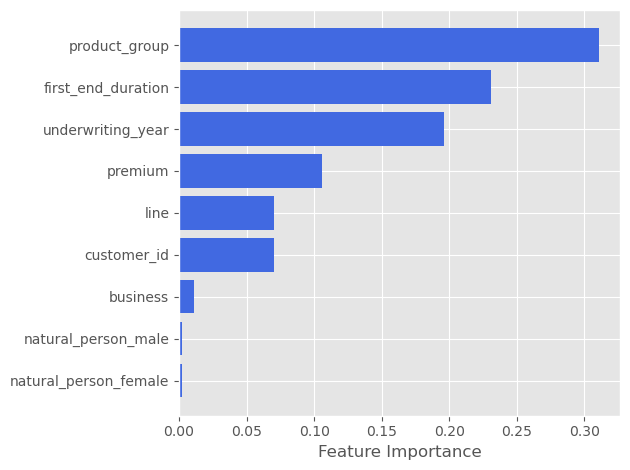

In [110]:
# Visualization 4: Random Forest Classifier feature importance

features_c = data_c.columns
features_c = features_c.drop('duration_status')
sorted_idx = RF_ft_imp.argsort()

plt.barh(features_c[sorted_idx], RF_ft_imp[sorted_idx], color = 'royalblue')
plt.xlabel("Feature Importance")

# saving the figure
plt.tight_layout()
plt.savefig('RFC_feature_importance.png')
plt.show()

Total number of predictions: 10245799


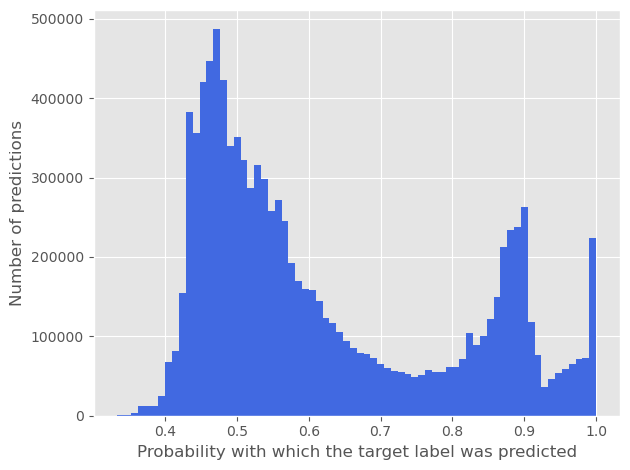

In [133]:
# Visualization 5: Probability with which the classifier output (0,1,2) was predicted

y_proba_1 = [max(i) for i in RF_proba[0]]
y_proba_2 = [max(i) for i in RF_proba[1]]
y_proba_3 = [max(i) for i in RF_proba[2]]
y_proba_4 = [max(i) for i in RF_proba[3]]
y_proba_5 = [max(i) for i in RF_proba[4]]

max_proba = list(itertools.chain(y_proba_1, y_proba_2, y_proba_3, y_proba_4, y_proba_5)) 
num_of_predictions = len(max_proba)
print('Total number of predictions:', num_of_predictions)

plt.hist(max_proba, bins=70, color = 'royalblue')
plt.xlabel('Probability with which the target label was predicted')
plt.ylabel('Number of predictions')

# saving the figure
plt.tight_layout()
plt.savefig('prediction_probability.png')
plt.show()